In [35]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import QTable
import numpy as np
from reproject import reproject_interp
import os 
from tqdm import tqdm 
from astropy.table import join

import warnings
warnings.filterwarnings('ignore')

# plt.style.use('paper.mplstyle')
from imports import *

In [36]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table_wprops = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wprops.fits' %root_dir)
table_wasso = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations.fits' %root_dir)
table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir)
table_muse_masked = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3_HSTFOV.fits' %root_dir)

table = table[table['flag_star_MUSE']!=1]
table_wprops = table_wprops[table_wprops['flag_star_MUSE']!=1]
table_muse = table_muse[table_muse['flag_star']!=1]

mask_hii = table_wasso['HII_class_v3_MUSE']==1
mask_noasso = ~table_wasso['no_associations_association_nuv_32pc']
table_wasso = table_wasso[mask_noasso&mask_hii]

if len(table) != len(table_wprops):
    print('Warning: Tables are not the same length!')

In [37]:
# Return if the region in the MUSE catalogue is detected in the HST catalogue
# Then append this to the MUSE catalogue (such that we have MUSE catalogue + detection flag)

run_detections = True
if run_detections: 
    
    detections_all = []
    gal_names = np.unique(table_muse_masked['gal_name'])
    for gal_name in tqdm(gal_names): 

        table_muse_masked_gal = table_muse_masked[table_muse_masked['gal_name'] == gal_name]
        table_hst_gal = table[table['gal_name'] == gal_name]

        region_IDs = table_muse_masked_gal['region_ID']
        detections = np.ones(len(region_IDs), dtype=bool)

        for i, region_ID in enumerate(region_IDs):

            if region_ID not in table_hst_gal['region_ID']:
                detection = False
            else : 
                detection = True

            detections[i] = detection

        detections_all += [detections]

    detections_all = np.concatenate(detections_all)
    table_muse_masked.add_column(detections_all, name='detection')

100%|██████████| 18/18 [00:00<00:00, 20.79it/s]


In [38]:
def get_completeness(xdata, ydata=None, binlims=None, bincent=None, nbins=20, dolog=True):

    if ydata is None:
        ydata = np.ones(len(xdata))

    if dolog:
        xdata = np.log10(np.array(xdata))

    if binlims is None:

        binmin = np.nanmin(xdata)
        binmax = np.nanmax(xdata)
        nbins = 20

        binlims = np.linspace(binmin, binmax, nbins)

    nbins = len(binlims)
    bincent = binlims[:-1]+((binlims[1:] - binlims[:-1])/2)
    
    sum_value_bin = np.zeros(nbins-1)*np.nan         # total value of regions in each bin
    sum_n_bins = np.zeros(nbins-1)*np.nan           # number of detections in each bin
    # tot_value_bins = np.zeros(nbins-1)*np.nan       
    tot_n_bins = np.zeros(nbins-1)*np.nan  
    frac_n_bins = np.zeros(nbins-1)*np.nan           # fraction of detections in each bin    

    for i in range(len(bincent)): 
        
        mask = (xdata>binlims[i]) & (xdata<binlims[i+1])

        xdata_bin = xdata[mask]
        ydata_bin = ydata[mask]

        if dolog:
            sum_value_bin[i] = np.log10(np.nansum(10**xdata_bin)) # total value of regions in each bin (log space)
            if not np.isfinite(sum_value_bin[i]):
                sum_value_bin[i] = np.nan
        else: 
            sum_value_bin[i] = np.nansum(xdata_bin) # total value of regions in each bin
        sum_n_bins[i] = np.nansum(ydata_bin*1) # number of detections in each bin

        # tot_value_bins[i] = np.nansum(10**xdata_bin)
        tot_n_bins[i] = np.nansum(mask)  # number of regions in each bin

        frac_n_bins[i] = sum_n_bins[i]/tot_n_bins[i]
        
    return bincent, sum_value_bin, sum_n_bins, tot_n_bins, frac_n_bins, binlims

binlims = np.linspace(35, 42, 25)
Lbin_MUSE, Ltot_MUSE, L_num_MUSE, L_numtot_MUSE, Lcomp_num_MUSE, binlims = get_completeness(table_muse_masked['Lum_HA6562_CORR'], detections_all, binlims=binlims) #MUSE data
Lbin_HST, Ltot_HST, L_num_HST, L_numtot_HST, Lcomp_num_HST, _ = get_completeness(table['HA6562_LUMINOSITY_HST'], binlims=binlims, bincent=Lbin_MUSE) #HST data (all detections = 1)

# Scent, S_num, Scomp_num = get_completeness(np.log10(table_muse_masked['HA6562_FLUX']/(table_muse_masked['region_area'])*0.2**2), detections_all, nbins=15)

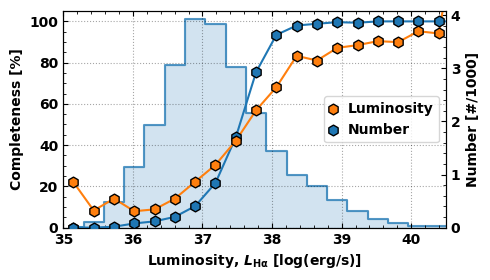

In [55]:
data_x1 = Lbin_MUSE
data_y1 = Lcomp_num_MUSE *100
data_z1 = L_numtot_MUSE/1000

data_x2 = Lbin_HST
data_y2 = 10**(Ltot_HST-Ltot_MUSE) *100

colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

fig = plt.figure(figsize=(5, 2.9)) 
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(data_x1, data_y1)
ax1.plot(data_x2, data_y2, color='C1')

ax1.scatter(data_x1[0], data_y1[0], s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1, label=r'Luminosity')
ax1.scatter(data_x1, data_y1, s=60, ec='black', fc='C0', zorder=10, marker='h', lw=1, label=r'Number')
ax1.scatter(data_x2, data_y2, s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1)

ax2.plot(data_x1, data_z1, color='C0', alpha=0.75, ds='steps-mid', zorder=0)
ax2.fill_between(data_x1, data_z1, alpha=0.2, step='mid', color='C0', zorder=0)

ax1.scatter(np.nan, np.nan, s=50, marker='s', ec=colors1[0], fc=colors2[0], label=r'')
ax1.scatter(np.nan, np.nan, s=50, marker='s', ec=colors1[1], fc=colors2[1], label=r'')

ax1.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel(r'Luminosity, $L_\mathrm{H\alpha}$ [log(erg/s)]')
ax1.set_ylabel('Completeness [%]')

ax2.set_ylabel('Number [#/1000]')

ax1.set_ylim(0, 105)
ax2.set_xlim(35, 40.5)
ax2.set_ylim(0, max(data_z1)*1.04)

ax1.legend(loc='center right', handlelength=0.5)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax1.set_zorder(1)

ax1.patch.set_visible(False)
ax2.patch.set_visible(False)

fig.savefig('./figs/scatter_completeness.pdf', dpi=200, bbox_inches='tight')

In [54]:
from scipy.interpolate import interp1d
interp_func1 = interp1d(data_y1, data_x1)
interp_func2 = interp1d(data_y2, data_x2)

L50 = interp_func1(50)
S50 = interp_func2(50)

print('L50: %0.1f' %L50)
print('S50: %0.1f' %S50)

L50: 37.5
S50: 37.6
